---
# <center>Dataset creation

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from tqdm import tqdm

#################################
# Dataset and Data Preparation  #
#################################

class SubsetSC(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, subset: str = None, root="./datasets/speechcommand", download=True):
        # Creates the directory where download the dataset if it doesn't exists.
        if not os.path.exists(root) and download:
            os.mkdir(root)
        super().__init__(root=root, download=download)
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.join(self._path, line.strip()) for line in f]
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


class InMemorySpeechCommands(Dataset):
    def __init__(self, subset="training", fixed_length=16000):
        """
        Args:
          subset: One of "training", "validation", "testing".
          fixed_length: The desired number of audio samples per clip.
        """
        self.fixed_length = fixed_length
        self.dataset = SubsetSC(subset=subset, root="./datasets/speechcommand", download=True)
        self.data = []
        self.labels = []
        
        # Build label index from the dataset's actual folder location
        dataset_root = self.dataset._path  # use the path used by the dataset
        all_labels = [
            d for d in os.listdir(dataset_root)
            if os.path.isdir(os.path.join(dataset_root, d)) and d != '_background_noise_'
        ]
        self.label_set = sorted(all_labels)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.label_set)}
        print(f"Found {len(self.label_set)} labels: {self.label_set}")
        
        # Load all samples into memory (resample, pad/trim)
        for waveform, sample_rate, label, *_ in tqdm(self.dataset, desc=f"Loading {subset} data", leave=False):
            if sample_rate != 16000:
                resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
                waveform = resampler(waveform)
            waveform = waveform.squeeze(0)  # Remove channel dimension if exists
            if waveform.size(0) > fixed_length:
                waveform = waveform[:fixed_length]
            elif waveform.size(0) < fixed_length:
                waveform = F.pad(waveform, (0, fixed_length - waveform.size(0)))
            self.data.append(waveform)
            try:
                self.labels.append(self.label_to_idx[label])
            except KeyError:
                # If a label is encountered that's not in our mapping, add it
                # (or alternatively, you could skip it or raise an error)
                new_idx = len(self.label_to_idx)
                print(f"New label found: {label}. Assigning new index {new_idx}")
                self.label_to_idx[label] = new_idx
                self.label_set.append(label)
                self.labels.append(new_idx)
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.fixed_length, self.labels[idx]



---
# <center>Model Architecture

In [2]:
class MaskedConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride,
                              padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.padding = padding
        self.dilation = dilation
        self.stride = stride
        self.kernel_size = kernel_size

    def forward(self, x, length):
        max_length = x.size(2)
        length = torch.div(((length + 2 * self.padding - self.dilation * (self.kernel_size - 1) - 1).float() + self.stride),
                           self.stride, rounding_mode='floor').long()
        mask = torch.arange(max_length, device=x.device)[None, :] < length[:, None]
        x = x * mask.unsqueeze(1)
        x = self.conv(x)
        return x, length

class JasperBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, dropout=0.0, residual=False):
        super().__init__()
        self.mconv = nn.ModuleList([
            MaskedConv1d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=in_channels, bias=False),
            MaskedConv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(out_channels)
        ])
        self.res = None
        if residual:
            self.res = nn.ModuleList([
                nn.ModuleList([
                    MaskedConv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm1d(out_channels)
                ])
            ])
        self.mout = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout)
        )

    def forward(self, x, length):
        residual = x
        res_length = length
        out = x
        out_length = length
        for layer in self.mconv:
            if isinstance(layer, MaskedConv1d):
                out, out_length = layer(out, out_length)
            else:
                out = layer(out)
        if self.res:
            for res_layer_list in self.res:
                res = residual
                for layer in res_layer_list:
                    if isinstance(layer, MaskedConv1d):
                        res, _ = layer(res, res_length)
                    else:
                        res = layer(res)
                residual = res
        if self.res is not None:
            out = out + residual
        out = self.mout(out)
        return out, out_length

class ConvASREncoder(nn.Module):
    def __init__(self, in_channels, blocks_params):
        super().__init__()
        layers = [JasperBlock(**params) for params in blocks_params]
        self.encoder = nn.Sequential(*layers)
        self.in_channels = in_channels

    def forward(self, x, length):
        for layer in self.encoder:
            x, length = layer(x, length)
        return x, length

class AudioToMFCCPreprocessor(nn.Module):
    def __init__(self, sample_rate=16000, n_mels=64, n_mfcc=64, n_fft=512, hop_length=160, f_min=0, f_max=8000):
        super().__init__()
        self.featurizer = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={
                "n_fft": n_fft,
                "n_mels": n_mels,
                "hop_length": hop_length,
                "f_min": f_min,
                "f_max": f_max,
            },
        )

    def forward(self, x, length):
        with torch.no_grad():
            x = self.featurizer(x)
        return x, length

class ConvASRDecoderClassification(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.pooling = nn.AdaptiveAvgPool1d(output_size=1)
        self.decoder_layers = nn.Sequential(
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.pooling(x)
        x = x.squeeze(2)
        x = self.decoder_layers(x)
        return x

class TopKClassificationAccuracy(nn.Module):
    def __init__(self, k=(1,)):
        super().__init__()
        self.k = k

    def forward(self, logits, targets):
        with torch.no_grad():
            maxk = max(self.k)
            batch_size = targets.size(0)
            _, pred = logits.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(targets.view(1, -1).expand_as(pred))
            res = []
            for k in self.k:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.mul_(100.0 / batch_size))
            return res[0] if len(res) == 1 else res

class EncDecClassificationModel(nn.Module):
    def __init__(self, num_classes, sample_rate=16000, n_mels=64, n_mfcc=64, n_fft=512, hop_length=160, f_min=0, f_max=8000):
        super().__init__()
        self.preprocessor = AudioToMFCCPreprocessor(
            sample_rate=sample_rate, n_mels=n_mels, n_mfcc=n_mfcc,
            n_fft=n_fft, hop_length=hop_length, f_min=f_min, f_max=f_max)
        blocks_params = [
            {"in_channels": n_mfcc, "out_channels": 128, "kernel_size": 11, "stride": 1, "padding": 5, "dilation": 1, "dropout": 0.0, "residual": False},
            {"in_channels": 128, "out_channels": 64, "kernel_size": 13, "stride": 1, "padding": 6, "dilation": 1, "dropout": 0.0, "residual": True},
            {"in_channels": 64, "out_channels": 64, "kernel_size": 15, "stride": 1, "padding": 7, "dilation": 1, "dropout": 0.0, "residual": True},
            {"in_channels": 64, "out_channels": 64, "kernel_size": 17, "stride": 1, "padding": 8, "dilation": 1, "dropout": 0.0, "residual": True},
            {"in_channels": 64, "out_channels": 128, "kernel_size": 29, "stride": 1, "padding": 28, "dilation": 2, "dropout": 0.0, "residual": False},
            {"in_channels": 128, "out_channels": 128, "kernel_size": 1, "stride": 1, "padding": 0, "dilation": 1, "dropout": 0.0, "residual": False},
        ]
        self.encoder = ConvASREncoder(in_channels=n_mfcc, blocks_params=blocks_params)
        self.decoder = ConvASRDecoderClassification(in_features=128, num_classes=num_classes)
        self.loss = nn.CrossEntropyLoss()
        self._accuracy = TopKClassificationAccuracy()

    def forward(self, x, length, y=None):
        x, length = self.preprocessor(x, length)
        x, length = self.encoder(x, length)
        logits = self.decoder(x)
        if y is not None:
            loss = self.loss(logits, y)
            acc = self._accuracy(logits, y)
            return loss, acc, logits
        else:
            return logits

    def predict(self, x, length):
        with torch.no_grad():
            logits = self.forward(x, length)
            return torch.argmax(logits, dim=-1)


---
# <center>Training

In [3]:
def train_epoch(model, train_loader, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for waveforms, lengths, labels in progress_bar:
        waveforms = waveforms.to(device)
        lengths = torch.tensor([lengths]).to(device) if isinstance(lengths, int) else lengths.to(device)
        labels = torch.tensor(labels).to(device) if isinstance(labels, int) else labels.to(device)

        optimizer.zero_grad()
        loss, acc, _ = model(waveforms, lengths, labels)
        loss.backward()
        optimizer.step()

        batch_size = waveforms.size(0)
        running_loss += loss.item() * batch_size
        running_accuracy += acc.item() * batch_size
        total_samples += batch_size

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{acc.item():.2f}%"})
    epoch_loss = running_loss / total_samples
    epoch_accuracy = running_accuracy / total_samples
    return epoch_loss, epoch_accuracy

def validate_epoch(model, val_loader, device, epoch):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    total_samples = 0

    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
    with torch.no_grad():
        for waveforms, lengths, labels in progress_bar:
            waveforms = waveforms.to(device)
            lengths = torch.tensor([lengths]).to(device) if isinstance(lengths, int) else lengths.to(device)
            labels = torch.tensor(labels).to(device) if isinstance(labels, int) else labels.to(device)

            loss, acc, _ = model(waveforms, lengths, labels)
            batch_size = waveforms.size(0)
            running_loss += loss.item() * batch_size
            running_accuracy += acc.item() * batch_size
            total_samples += batch_size

            progress_bar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{acc.item():.2f}%"})
    epoch_loss = running_loss / total_samples
    epoch_accuracy = running_accuracy / total_samples
    return epoch_loss, epoch_accuracy

In [57]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

In [58]:
# Configuration
num_epochs = 60
batch_size = 64
learning_rate = 0.001
sample_rate = 16000
fixed_length = sample_rate  # 1 second clips (SpeechCommands are ~1 sec)

# Prepare datasets (in-memory)
print("Preparing datasets...")
train_dataset = InMemorySpeechCommands(subset="training", fixed_length=fixed_length)
val_dataset = InMemorySpeechCommands(subset="validation", fixed_length=fixed_length)
num_classes = len(train_dataset.label_set)
print("Label set:", train_dataset.label_set)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize model, optimizer
model = EncDecClassificationModel(num_classes=num_classes, sample_rate=sample_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

    # Wrap epoch loop with tqdm for overall progress monitoring
for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs"):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, epoch)
    val_loss, val_acc = validate_epoch(model, val_loader, device, epoch)
    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    # Save the best model
    if val_acc > 0:
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
print("Training complete.")

Preparing datasets...
Found 35 labels: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


Found 35 labels: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


Label set: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
Using device: cuda


Epochs:   2%|█                                                               | 1/60 [00:29<29:07, 29.62s/it]

Epoch 1: Train Loss: 0.7258, Train Acc: 80.19%, Val Loss: 0.3331, Val Acc: 89.90%
Saved best model!


Epochs:   3%|██▏                                                             | 2/60 [00:58<28:20, 29.32s/it]

Epoch 2: Train Loss: 0.2896, Train Acc: 91.35%, Val Loss: 0.1869, Val Acc: 94.33%
Saved best model!


Epochs:   5%|███▏                                                            | 3/60 [01:27<27:40, 29.13s/it]

Epoch 3: Train Loss: 0.2309, Train Acc: 93.10%, Val Loss: 0.1562, Val Acc: 95.27%
Saved best model!


Epochs:   7%|████▎                                                           | 4/60 [01:56<26:56, 28.87s/it]

Epoch 4: Train Loss: 0.1980, Train Acc: 93.96%, Val Loss: 0.1452, Val Acc: 95.25%
Saved best model!


Epochs:   8%|█████▎                                                          | 5/60 [02:25<26:31, 28.95s/it]

Epoch 5: Train Loss: 0.1755, Train Acc: 94.64%, Val Loss: 0.1306, Val Acc: 95.92%
Saved best model!


Epochs:  10%|██████▍                                                         | 6/60 [02:54<26:03, 28.96s/it]

Epoch 6: Train Loss: 0.1556, Train Acc: 95.22%, Val Loss: 0.1174, Val Acc: 96.64%
Saved best model!


Epochs:  12%|███████▍                                                        | 7/60 [03:23<25:41, 29.09s/it]

Epoch 7: Train Loss: 0.1390, Train Acc: 95.74%, Val Loss: 0.0983, Val Acc: 96.79%
Saved best model!


Epochs:  13%|████████▌                                                       | 8/60 [03:52<25:10, 29.05s/it]

Epoch 8: Train Loss: 0.1260, Train Acc: 96.04%, Val Loss: 0.0888, Val Acc: 97.23%
Saved best model!


Epochs:  15%|█████████▌                                                      | 9/60 [04:22<24:49, 29.21s/it]

Epoch 9: Train Loss: 0.1117, Train Acc: 96.56%, Val Loss: 0.0736, Val Acc: 97.80%
Saved best model!


Epochs:  17%|██████████▌                                                    | 10/60 [04:51<24:19, 29.19s/it]

Epoch 10: Train Loss: 0.0999, Train Acc: 96.94%, Val Loss: 0.0634, Val Acc: 98.12%
Saved best model!


Epochs:  18%|███████████▌                                                   | 11/60 [05:20<23:48, 29.16s/it]

Epoch 11: Train Loss: 0.0886, Train Acc: 97.24%, Val Loss: 0.0507, Val Acc: 98.48%
Saved best model!


Epochs:  20%|████████████▌                                                  | 12/60 [05:49<23:19, 29.16s/it]

Epoch 12: Train Loss: 0.0772, Train Acc: 97.65%, Val Loss: 0.0460, Val Acc: 98.68%
Saved best model!


Epochs:  22%|█████████████▋                                                 | 13/60 [06:20<23:14, 29.67s/it]

Epoch 13: Train Loss: 0.0703, Train Acc: 97.87%, Val Loss: 0.0380, Val Acc: 98.92%
Saved best model!


Epochs:  23%|██████████████▋                                                | 14/60 [06:49<22:36, 29.48s/it]

Epoch 14: Train Loss: 0.0603, Train Acc: 98.25%, Val Loss: 0.0319, Val Acc: 99.18%
Saved best model!


Epochs:  25%|███████████████▊                                               | 15/60 [07:18<22:02, 29.40s/it]

Epoch 15: Train Loss: 0.0545, Train Acc: 98.43%, Val Loss: 0.0284, Val Acc: 99.30%
Saved best model!


Epochs:  27%|████████████████▊                                              | 16/60 [07:47<21:30, 29.34s/it]

Epoch 16: Train Loss: 0.0492, Train Acc: 98.65%, Val Loss: 0.0239, Val Acc: 99.50%
Saved best model!


Epochs:  28%|█████████████████▊                                             | 17/60 [08:16<20:59, 29.30s/it]

Epoch 17: Train Loss: 0.0444, Train Acc: 98.76%, Val Loss: 0.0223, Val Acc: 99.51%
Saved best model!


Epochs:  30%|██████████████████▉                                            | 18/60 [08:46<20:33, 29.37s/it]

Epoch 18: Train Loss: 0.0414, Train Acc: 98.90%, Val Loss: 0.0207, Val Acc: 99.57%
Saved best model!


Epochs:  32%|███████████████████▉                                           | 19/60 [09:16<20:07, 29.45s/it]

Epoch 19: Train Loss: 0.0386, Train Acc: 99.00%, Val Loss: 0.0199, Val Acc: 99.57%
Saved best model!


Epochs:  33%|█████████████████████                                          | 20/60 [09:46<19:43, 29.58s/it]

Epoch 20: Train Loss: 0.0377, Train Acc: 99.03%, Val Loss: 0.0193, Val Acc: 99.59%
Saved best model!


Epochs:  35%|██████████████████████                                         | 21/60 [10:15<19:13, 29.59s/it]

Epoch 21: Train Loss: 0.0377, Train Acc: 99.03%, Val Loss: 0.0195, Val Acc: 99.60%
Saved best model!


Epochs:  37%|███████████████████████                                        | 22/60 [10:44<18:39, 29.47s/it]

Epoch 22: Train Loss: 0.0376, Train Acc: 99.04%, Val Loss: 0.0195, Val Acc: 99.59%
Saved best model!


Epochs:  38%|████████████████████████▏                                      | 23/60 [11:14<18:07, 29.40s/it]

Epoch 23: Train Loss: 0.0379, Train Acc: 99.01%, Val Loss: 0.0190, Val Acc: 99.61%
Saved best model!


Epochs:  40%|█████████████████████████▏                                     | 24/60 [11:43<17:36, 29.35s/it]

Epoch 24: Train Loss: 0.0382, Train Acc: 99.02%, Val Loss: 0.0186, Val Acc: 99.59%
Saved best model!


Epochs:  42%|██████████████████████████▎                                    | 25/60 [12:12<17:05, 29.29s/it]

Epoch 25: Train Loss: 0.0398, Train Acc: 98.92%, Val Loss: 0.0177, Val Acc: 99.61%
Saved best model!


Epochs:  43%|███████████████████████████▎                                   | 26/60 [12:41<16:37, 29.33s/it]

Epoch 26: Train Loss: 0.0414, Train Acc: 98.85%, Val Loss: 0.0184, Val Acc: 99.56%
Saved best model!


Epochs:  45%|████████████████████████████▎                                  | 27/60 [13:11<16:06, 29.28s/it]

Epoch 27: Train Loss: 0.0425, Train Acc: 98.81%, Val Loss: 0.0203, Val Acc: 99.45%
Saved best model!


Epochs:  47%|█████████████████████████████▍                                 | 28/60 [13:40<15:35, 29.25s/it]

Epoch 28: Train Loss: 0.0468, Train Acc: 98.61%, Val Loss: 0.0216, Val Acc: 99.43%
Saved best model!


Epochs:  48%|██████████████████████████████▍                                | 29/60 [14:09<15:04, 29.17s/it]

Epoch 29: Train Loss: 0.0513, Train Acc: 98.42%, Val Loss: 0.0234, Val Acc: 99.31%
Saved best model!


Epochs:  50%|███████████████████████████████▌                               | 30/60 [14:38<14:36, 29.21s/it]

Epoch 30: Train Loss: 0.0553, Train Acc: 98.27%, Val Loss: 0.0270, Val Acc: 99.20%
Saved best model!


Epochs:  52%|████████████████████████████████▌                              | 31/60 [15:07<14:08, 29.26s/it]

Epoch 31: Train Loss: 0.0603, Train Acc: 98.10%, Val Loss: 0.0281, Val Acc: 99.26%
Saved best model!


Epochs:  53%|█████████████████████████████████▌                             | 32/60 [15:37<13:39, 29.26s/it]

Epoch 32: Train Loss: 0.0652, Train Acc: 97.89%, Val Loss: 0.0328, Val Acc: 99.04%
Saved best model!


Epochs:  55%|██████████████████████████████████▋                            | 33/60 [16:06<13:14, 29.43s/it]

Epoch 33: Train Loss: 0.0706, Train Acc: 97.73%, Val Loss: 0.0381, Val Acc: 98.82%
Saved best model!


Epochs:  57%|███████████████████████████████████▋                           | 34/60 [16:36<12:47, 29.53s/it]

Epoch 34: Train Loss: 0.0722, Train Acc: 97.66%, Val Loss: 0.0416, Val Acc: 98.59%
Saved best model!


Epochs:  58%|████████████████████████████████████▊                          | 35/60 [17:07<12:24, 29.79s/it]

Epoch 35: Train Loss: 0.0792, Train Acc: 97.47%, Val Loss: 0.0468, Val Acc: 98.40%
Saved best model!


Epochs:  60%|█████████████████████████████████████▊                         | 36/60 [17:39<12:10, 30.44s/it]

Epoch 36: Train Loss: 0.0800, Train Acc: 97.45%, Val Loss: 0.0477, Val Acc: 98.49%
Saved best model!


Epochs:  62%|██████████████████████████████████████▊                        | 37/60 [18:09<11:42, 30.56s/it]

Epoch 37: Train Loss: 0.0798, Train Acc: 97.46%, Val Loss: 0.0493, Val Acc: 98.37%
Saved best model!


Epochs:  63%|███████████████████████████████████████▉                       | 38/60 [18:40<11:12, 30.59s/it]

Epoch 38: Train Loss: 0.0827, Train Acc: 97.29%, Val Loss: 0.0520, Val Acc: 98.39%
Saved best model!


Epochs:  65%|████████████████████████████████████████▉                      | 39/60 [19:14<11:01, 31.49s/it]

Epoch 39: Train Loss: 0.0784, Train Acc: 97.47%, Val Loss: 0.0565, Val Acc: 98.22%
Saved best model!


Epochs:  67%|██████████████████████████████████████████                     | 40/60 [19:49<10:53, 32.69s/it]

Epoch 40: Train Loss: 0.0780, Train Acc: 97.49%, Val Loss: 0.0482, Val Acc: 98.55%
Saved best model!


Epochs:  68%|███████████████████████████████████████████                    | 41/60 [20:20<10:09, 32.08s/it]

Epoch 41: Train Loss: 0.0772, Train Acc: 97.48%, Val Loss: 0.0422, Val Acc: 98.64%
Saved best model!


Epochs:  70%|████████████████████████████████████████████                   | 42/60 [20:50<09:26, 31.45s/it]

Epoch 42: Train Loss: 0.0727, Train Acc: 97.68%, Val Loss: 0.0422, Val Acc: 98.66%
Saved best model!


Epochs:  72%|█████████████████████████████████████████████▏                 | 43/60 [21:20<08:47, 31.02s/it]

Epoch 43: Train Loss: 0.0707, Train Acc: 97.76%, Val Loss: 0.0384, Val Acc: 98.80%
Saved best model!


Epochs:  73%|██████████████████████████████████████████████▏                | 44/60 [21:50<08:11, 30.70s/it]

Epoch 44: Train Loss: 0.0668, Train Acc: 97.87%, Val Loss: 0.0399, Val Acc: 98.74%
Saved best model!


Epochs:  75%|███████████████████████████████████████████████▎               | 45/60 [22:20<07:37, 30.50s/it]

Epoch 45: Train Loss: 0.0621, Train Acc: 98.06%, Val Loss: 0.0411, Val Acc: 98.69%
Saved best model!


Epochs:  77%|████████████████████████████████████████████████▎              | 46/60 [22:50<07:04, 30.29s/it]

Epoch 46: Train Loss: 0.0579, Train Acc: 98.19%, Val Loss: 0.0291, Val Acc: 99.05%
Saved best model!


Epochs:  78%|█████████████████████████████████████████████████▎             | 47/60 [23:19<06:31, 30.11s/it]

Epoch 47: Train Loss: 0.0508, Train Acc: 98.43%, Val Loss: 0.0282, Val Acc: 99.21%
Saved best model!


Epochs:  80%|██████████████████████████████████████████████████▍            | 48/60 [23:49<06:01, 30.09s/it]

Epoch 48: Train Loss: 0.0467, Train Acc: 98.54%, Val Loss: 0.0257, Val Acc: 99.26%
Saved best model!


Epochs:  82%|███████████████████████████████████████████████████▍           | 49/60 [24:19<05:30, 30.07s/it]

Epoch 49: Train Loss: 0.0411, Train Acc: 98.76%, Val Loss: 0.0176, Val Acc: 99.51%
Saved best model!


Epochs:  83%|████████████████████████████████████████████████████▌          | 50/60 [24:49<05:00, 30.02s/it]

Epoch 50: Train Loss: 0.0368, Train Acc: 98.87%, Val Loss: 0.0155, Val Acc: 99.57%
Saved best model!


Epochs:  85%|█████████████████████████████████████████████████████▌         | 51/60 [25:19<04:29, 29.99s/it]

Epoch 51: Train Loss: 0.0333, Train Acc: 99.03%, Val Loss: 0.0149, Val Acc: 99.59%
Saved best model!


Epochs:  87%|██████████████████████████████████████████████████████▌        | 52/60 [25:49<03:58, 29.87s/it]

Epoch 52: Train Loss: 0.0287, Train Acc: 99.17%, Val Loss: 0.0115, Val Acc: 99.71%
Saved best model!


Epochs:  88%|███████████████████████████████████████████████████████▋       | 53/60 [26:18<03:28, 29.79s/it]

Epoch 53: Train Loss: 0.0250, Train Acc: 99.32%, Val Loss: 0.0093, Val Acc: 99.75%
Saved best model!


Epochs:  90%|████████████████████████████████████████████████████████▋      | 54/60 [26:51<03:03, 30.51s/it]

Epoch 54: Train Loss: 0.0212, Train Acc: 99.45%, Val Loss: 0.0074, Val Acc: 99.83%
Saved best model!


Epochs:  92%|█████████████████████████████████████████████████████████▊     | 55/60 [27:20<02:30, 30.18s/it]

Epoch 55: Train Loss: 0.0190, Train Acc: 99.50%, Val Loss: 0.0065, Val Acc: 99.87%
Saved best model!


Epochs:  93%|██████████████████████████████████████████████████████████▊    | 56/60 [27:49<01:59, 30.00s/it]

Epoch 56: Train Loss: 0.0166, Train Acc: 99.58%, Val Loss: 0.0051, Val Acc: 99.90%
Saved best model!


Epochs:  95%|███████████████████████████████████████████████████████████▊   | 57/60 [28:19<01:29, 29.87s/it]

Epoch 57: Train Loss: 0.0150, Train Acc: 99.61%, Val Loss: 0.0049, Val Acc: 99.90%
Saved best model!


Epochs:  97%|████████████████████████████████████████████████████████████▉  | 58/60 [28:48<00:59, 29.72s/it]

Epoch 58: Train Loss: 0.0135, Train Acc: 99.68%, Val Loss: 0.0043, Val Acc: 99.92%
Saved best model!


Epochs:  98%|█████████████████████████████████████████████████████████████▉ | 59/60 [29:18<00:29, 29.68s/it]

Epoch 59: Train Loss: 0.0128, Train Acc: 99.69%, Val Loss: 0.0041, Val Acc: 99.91%
Saved best model!


Epochs: 100%|███████████████████████████████████████████████████████████████| 60/60 [29:47<00:00, 29.80s/it]

Epoch 60: Train Loss: 0.0122, Train Acc: 99.71%, Val Loss: 0.0041, Val Acc: 99.91%
Saved best model!
Training complete.


In [71]:
import matplotlib.pyplot as plt

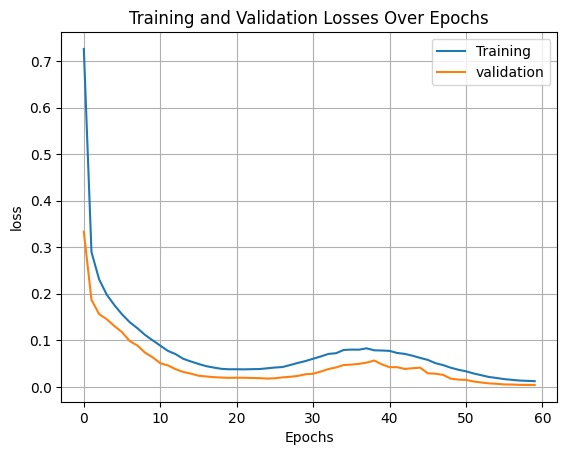

In [ ]:
plt.plot(range(len(train_losses)), train_losses, label="Training")
plt.plot(range(len(val_losses)), val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Training and Validation Losses Over Epochs")
plt.legend()
plt.grid()

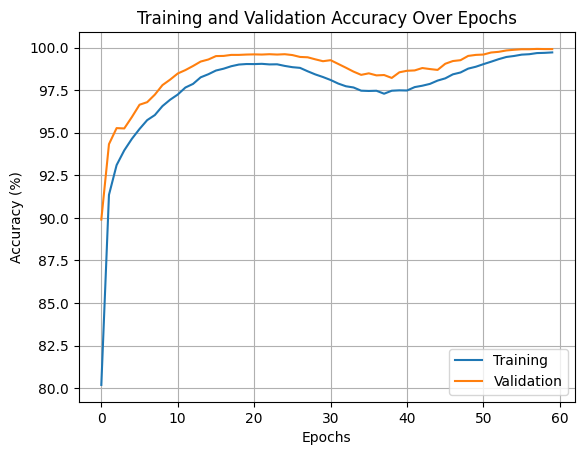

In [82]:
plt.plot(range(len(train_accs)), train_accs, label="Training")
plt.plot(range(len(val_accs)), val_accs, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.grid()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_accs)), train_accs)
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.title("Training accuracy")
plt.grid()

In [45]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

Total Trainable Parameters: 77987
